# Linear sweep voltammetry (LSV), parameter estimation
Peter Attia

This notebook plots the first lithiation of carbon black electrodes as a function of sweep rate. This notebook attempts to estimate the electrochemical parameters of the reaction, but I wasn't able to figure it out. Leaving this here for someone else to try.

This notebook frequently references Bard & Faulkner, which can be found [here](https://www.asu.edu/courses/mse590/Electrochem%20summer%202015/Electrochemical_methods_2ed_2001_-_Bard_Faulkner.pdf). Page 236 has most of the needed equations. Additionally, Bio-logic's [Application Note 41.1](https://www.biologic.net/wp-content/uploads/2019/08/cv-simulation_electrochemistry-an41-1.pdf) also has similar equations.

In [1]:
import re
import glob
from pathlib import Path

import numpy as np
from scipy.signal import savgol_filter
from scipy.integrate import cumtrapz
import pandas as pd
import pint

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Set plotting settings:

In [2]:
fig_width = 3.25 #ECS spec is 3.25" width
fig_height = (3/4)*fig_width # standard ratio
rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

figpath = Path.cwd().parent / 'figures'

## Define pint unit registry and common units

In this notebook, I use the `pint` package to reduce unit conversion errors in estimating the electrochemical parameters of this system.

In [3]:
ureg = pint.UnitRegistry()

#### Physical constants

Define commonly used physical constants. All data analyzed in this notebook was collected at 30°C:

In [4]:
F = ureg.faraday_constant
R = ureg.R
T = (273.15 + 30) * ureg.K

Define normalized Faraday's constant, `f`:

In [5]:
f = F / (R * T)
f.ito('V**-1') # in-place conversion
f

38.27978928434796 <Unit('1 / volt')>

Define typical electrode mass. Unfortunately, the true values were unavailable, so we use nominal masses here:

In [6]:
electrode_mass = 0.8 * ureg.mg

#### Electrode area

Define typical electrode area in cm^2:

In [7]:
SSA = 62 * ureg.m ** 2 / ureg.g # specific surface area of carbon black

electrode_area = SSA * electrode_mass
electrode_area.ito('cm**2')
electrode_area

496.0 <Unit('centimeter ** 2')>

#### EC concentration

Define concentration of EC in electrolyte. The electrolyte used in this work is 1.0 M LiPF6 in 1:1 EC:DEC by weight.

In [8]:
molar_mass_EC = 88.06 * ureg.g / ureg.mol
molar_mass_DEC = 118.13 * ureg.g / ureg.mol
molar_mass_LiPF6 = 151.905 * ureg.g / ureg.mol

conc_LiPF6 = 1 * ureg.M
density_soln = 1.26 * ureg.g / ureg.mL # https://www.sigmaaldrich.com/catalog/product/aldrich/746746?lang=en&region=US
volume_soln = 1 * ureg.L # 1 L of solution

In 1 L of electrolyte, how much mass of salt is there?

In [9]:
mass_soln = volume_soln * density_soln
mass_salt = conc_LiPF6 * volume_soln * molar_mass_LiPF6
mass_salt.to('g')

151.90500000000003 <Unit('gram')>

Find mass of EC:

In [10]:
mass_solvent = mass_soln - mass_salt
mass_EC = 0.5 * mass_solvent # EC is 50% of total solvent weight

Find concentration of EC in electrolyte:

In [11]:
C_EC = mass_EC / molar_mass_EC / volume_soln
C_EC.ito('mol / cm**3')
C_EC

0.006291704519645697 <Unit('mole / centimeter ** 3')>

## Load data

In [12]:
file_list = sorted(list((Path.cwd()).glob('*.txt')))
file_list

[PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellE_CB_LSV_3mVpermin_CB1.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellF_CB_LSV_10mVpermin_CB2.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellG_CB_LSV_30mVpermin_CB3.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellH_CB_LSV_100mVpermin_CB4.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/LSV/cellI_CB_LSV_300mVpermin_CB5.txt')]

#### Sanity check dVdt values and read in speeds

3 -3.000445268594945 0.6090303352423291 -0.20297998487655372
10 -10.002255003113708 0.5378946798955853 -0.0537773411823772
30 -29.939482586270127 1.5046745942106194 -0.05025720100121718
100 -100.02010430021092 0.6232664014496389 -0.006231411232874754
300 -300.05609981459264 0.7598870161055383 -0.002532483147568336


Text(0, 0.5, 'Voltage')

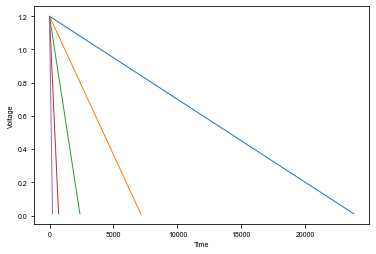

In [13]:
speeds = np.zeros((len(file_list), ))

for k, file in enumerate(file_list):
    data = np.genfromtxt(file, delimiter='\t', skip_header=True)
    speed = int(re.findall(r'\d+', str(file).split('_')[3])[0])
    speeds[k] = speed
    
    UCV = 1.2
    idx1 = np.where(data[:,2] < UCV)[0][0]
    data = data[idx1:]
    idx2 = np.where(data[:,0] == 1)[0][0]
    data = data[:idx2]
    
    dVdt = np.gradient(data[:,2] * 1000) / np.gradient(data[:,1] / 60) # V/s -> mV/min
    
    mean = np.mean(dVdt)
    std = np.std(dVdt)
    print(speed , mean, std, std/mean)
    
    plt.plot(data[:,1] - data[0,1], data[:,2])
    
plt.xlabel('Time')
plt.ylabel('Voltage')

Add speed units from `pint`:

In [14]:
speeds_units = np.asarray(speeds) * ureg.mV / ureg.min
speeds_units

array([  3.,  10.,  30., 100., 300.]) <Unit('millivolt / minute')>

Default speed units should be V/s:

In [15]:
speeds_units.ito('V/s')
speeds_units

array([5.00000000e-05, 1.66666667e-04, 5.00000000e-04, 1.66666667e-03,
       5.00000000e-03]) <Unit('volt / second')>

## Create $\Delta I$ to determine baseline currents

One of the challenges with this system is deconvoluting the EC reduction reaction from the carbon black intercalation reaction. We get around this by subtracting the first lithiation from the second lithiation to bypass this. Then, to get the actual peak current values, I manually define values for the baseline by voltage:

In [16]:
V_baselines = [0.98, 0.9, 0.8, 0.61, 0.46]

Define a standard voltage basis vector for interpolation:

In [17]:
Vlin = np.linspace(0, 1.2, 1000)

Preinitialize:

In [18]:
I_baseline = np.zeros((5,))
I_peak = np.zeros((5,))
V_peak = np.zeros((5,))

Create plot:

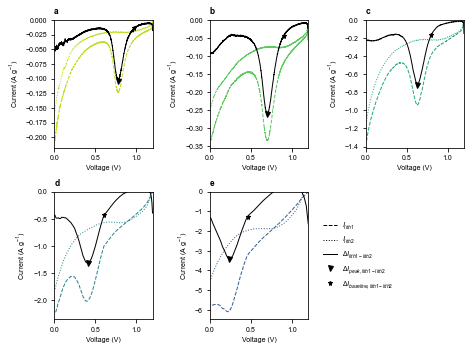

In [19]:
fig, ax = plt.subplots(figsize=(fig_width*2, fig_height*2), nrows=2, ncols=3)
ax = ax.ravel()

colors = cm.viridis(np.linspace(0.9, 0.3, 5))[:,0:3]

for k, file in enumerate(file_list):
    data = np.genfromtxt(file, delimiter='\t', skip_header=True)
    
    # Find first and second lithiations.
    # data[:,0] indicates the redox mode
    idx = np.where(data[:,0] == 0)[0]
    
    # transition_point = index splitting first and second lithiations
    transition_point = idx[:-1][np.diff(idx) != 1][0]
    idx1 = idx[idx < transition_point]
    idx2 = idx[idx > transition_point]
    data1 = np.flip(data[idx1], axis=0)
    data2 = np.flip(data[idx2], axis=0)

    # create linearly interpolated current vectors to enable direct subtraction
    mass_in_mg = electrode_mass.to('mg').magnitude
    Ilin1 = np.interp(Vlin, data1[:,2], data1[:,3] / mass_in_mg)
    Ilin2 = np.interp(Vlin, data2[:,2], data2[:,3] / mass_in_mg)
    
    # Create DeltaI
    DeltaI = Ilin1 - Ilin2
    
    # Find peak current and voltage
    peak_idx = np.argmin(DeltaI)
    I_peak[k] = DeltaI[peak_idx]
    V_peak[k] = Vlin[peak_idx]
    
    # Identify baseline current from manually selected baseline voltage
    idx_baseline = np.where(Vlin > V_baselines[k])[0][0]
    I_baseline[k] = DeltaI[idx_baseline]
    
    # Downsample first data series
    if k == 0:
        V1, I1 = data1[::5,2], data1[::5,3] / mass_in_mg
        V2, I2 = data2[::5,2], data2[::5,3] / mass_in_mg
    else:
        V1, I1 = data1[:,2], data1[:,3] / mass_in_mg
        V2, I2 = data2[:,2], data2[:,3] / mass_in_mg
    
    # Plot
    ax[k].plot(V1, I1, '--', color=colors[k], label='$I_{lith1}$')
    ax[k].plot(V2, I2, ':', color=colors[k], label='$I_{lith2}$')
    ax[k].plot(Vlin, DeltaI, color='k', label=r'$\Delta I_{lith1-lith2}$')
    ax[k].plot(V_peak[k], I_peak[k], 'vk', label=r'$\Delta I_{peak, lith1-lith2}$')
    ax[k].plot(V_baselines[k], I_baseline[k], '*k', label=r'$\Delta I_{baseline, lith1-lith2}$')
    
    # Plot settings
    ax[k].set_xlim([0, 1.2])
    ax[k].set_ylim(top=0)
    ax[k].set_xlabel('Voltage (V)')
    ax[k].set_ylabel('Current (A g$^{-1}$)')
    ax[k].set_title(chr(97+k), loc='left', weight='bold')

ax[5].axis('off')
ax[5].plot([-2, -1], [-2, -1], '--k', label='$I_{lith1}$')
ax[5].plot([-2, -1], [-2, -1], ':k', label='$I_{lith2}$')
ax[5].plot([-2, -1], [-2, -1], 'k', label=r'$\Delta I_{lith1-lith2}$')
ax[5].plot(-1, -1, 'vk', label=r'$\Delta I_{peak, lith1-lith2}$')
ax[5].plot(-1, -1, '*k', label=r'$\Delta I_{baseline, lith1-lith2}$')
ax[5].set_xlim([0, 1])
ax[5].set_ylim([0, 1])
ax[5].legend(loc='center left', bbox_to_anchor=(-0.5, 0.5))

plt.tight_layout()

## Electrochemical parameter estimation

From Bard and Faulkner. The strategy is:
1. Find $\alpha$
2. Find $D_0$
3. Find $k_0$ vs $E^0$. Note that these parameters can only be determined as a function of each other.

### Alpha

Get alpha from Eqn 6.3.11:

![Alpha](alpha.png)

First get half-peak potentials (baseline voltage + half the distance beteween the peak and baseline):

In [20]:
V_halfpeaks = V_baselines + (V_peak - V_baselines) / 2
V_halfpeaks

array([0.87738739, 0.79834835, 0.71291291, 0.5092042 , 0.34351351])

Then get $ |E_p - E_{p/2}| $:

In [21]:
Ep_minus_Epover2 = -(V_peak - V_halfpeaks) * ureg.V
Ep_minus_Epover2

array([0.10261261, 0.10165165, 0.08708709, 0.1007958 , 0.11648649]) <Unit('volt')>

Now calculate alpha for each point:

In [22]:
alpha = 1.857 / f / Ep_minus_Epover2
alpha

array([0.47276098, 0.47723021, 0.55704285, 0.48128236, 0.41645379]) <Unit('dimensionless')>

Pretty consistent overall! Check mean alpha:

In [23]:
alpha_mean = np.mean(alpha.magnitude)
alpha_mean

0.480954036493588

Seems reasonable.

### Find $ D_O $

From Eqn 6.3.6/6.3.8 ($\pi^{1/2}\chi(bt)=0.4958$):

![Ipeaks](Ipeaks.png)

We can regress $ I_{peak} $ vs $ \nu^{0.5} $ to obtain:
- slope = $ 0.4958 F A C_O^{*} D_O^{1/2} (\alpha f)^{1/2} $ 
- intercept = 0

Define `Ipeak_minus_Ibaseline`, which is `I_peak` relative to `I_baseline`:

In [24]:
Ipeak_minus_Ibaseline = -(I_peak - I_baseline) * ureg.A / ureg.g
Ipeak_minus_Ibaseline

array([0.08909758, 0.21644145, 0.55191809, 0.89228531, 2.14896928]) <Unit('ampere / gram')>

Convert from A / g to A:

In [25]:
Ipeak_minus_Ibaseline_current = Ipeak_minus_Ibaseline * electrode_mass
Ipeak_minus_Ibaseline_current.ito('A')
Ipeak_minus_Ibaseline_current

array([7.12780651e-05, 1.73153160e-04, 4.41534469e-04, 7.13828251e-04,
       1.71917542e-03]) <Unit('ampere')>

Plot sqrt(sweep rate) vs `Ipeak_minus_Ibaseline_current`:

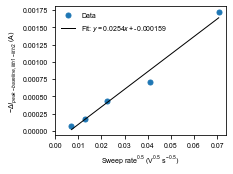

In [26]:
speeds_V_per_s = speeds_units.to('V/s').magnitude
Ipeak_minus_Ibaseline_A = Ipeak_minus_Ibaseline_current.to('A').magnitude
fit_Ipeak_vs_sqrt_sweep_rate = np.polyfit(speeds_V_per_s**0.5, Ipeak_minus_Ibaseline_A, 1)

sweep_rates_sqrt = np.linspace(speeds_V_per_s.min()**0.5, speeds_V_per_s.max()**0.5, 100)
fit_line = fit_Ipeak_vs_sqrt_sweep_rate[0] * sweep_rates_sqrt + fit_Ipeak_vs_sqrt_sweep_rate[1]

label = 'Fit: $y=$' + f'{fit_Ipeak_vs_sqrt_sweep_rate[0]:.3g}' + '$x + $' + f'{fit_Ipeak_vs_sqrt_sweep_rate[1]:.3g}'

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

ax.plot(speeds_V_per_s**(0.5), Ipeak_minus_Ibaseline_A, 'o', label='Data')
ax.plot(sweep_rates_sqrt, fit_line, '-k', label=label)

ax.set_xlabel('Sweep rate$^{0.5}$ (V$^{0.5}$ s$^{-0.5}$)')
ax.set_ylabel('$-\Delta I_{peak-baseline, lith1-lith2}$ (A)')
ax.set_xlim(left=0)
ax.legend()

fig.tight_layout()
fig.savefig(figpath / 'EC_diffusivity_estimate.eps', bbox_inches='tight', format='eps')

The intercept is not zero, but this should give us an order of magnitude estimate. Fairly linear overall.

View fit:

In [27]:
fit_Ipeak_vs_sqrt_sweep_rate

array([ 0.02542995, -0.00015882])

Add slope units:

In [28]:
slope_Ipeak_vs_sqrt_sweep_rate = fit_Ipeak_vs_sqrt_sweep_rate[0] * ureg.A / (ureg.V / ureg.s) ** 0.5
slope_Ipeak_vs_sqrt_sweep_rate

0.025429948211318068 <Unit('ampere * second ** 0.5 / volt ** 0.5')>

Estimate $D_O$ from equation 6.3.6:

$ D_O^{1/2} = \frac{slope}{0.4958 F A C_O^{*} (\alpha f)^{1/2}} $ 

In [29]:
denominator = 0.4958 * F * electrode_area * C_EC * ((alpha_mean * f) ** 0.5)
denominator.to('C / m / V**0.5')

64055196.78380366 <Unit('coulomb / meter / volt ** 0.5')>

In [30]:
D_O_sqrt = slope_Ipeak_vs_sqrt_sweep_rate / denominator
D_O = (D_O_sqrt ** 2).to('m**2 / s')
D_O

1.5760943493752488e-19 <Unit('meter ** 2 / second')>

This is unreasonable, as this is rounghly 10 orders of magnitude higher than literature values of $10^{-10} - 10^{-9} m^2/s$:
- [doi.org/10.1021/je3003089](doi.org/10.1021/je3003089)
- [doi.org/10.1149/2.0941712jes](doi.org/10.1149/2.0941712jes)

I'm not sure how to resolve this.

### Estimate $ k^0 $ & $ E^0 $

Eqn 6.3.12 shows the relationship between $ k^0 $ & $ E^0 $:

![E0 and k0](E0_and_k0.png)

If we do a bit of algebra, we can arrive at the relationship between $ k^0 $ and $ E^0 $:

$$i_p = 0.227 F A C_O k^0 \exp(-\alpha f (E_{peak} - E^0)) $$

$$\log(i_p) = \log(0.227 F A C_O k^0 ) -\alpha f (E_{peak} - E^0) $$

$$\log(i_p) = \log(0.227 F A C_O k^0 ) -\alpha f E_{peak} + \alpha f E^0 $$

If we define $y = \log(i_p)$ and $x = E_{peak} $ and fit to a line, then:

$$ slope = -\alpha f $$

$$ intercept = \log(0.227 F A C_O k^0 ) + \alpha f E^0 $$

Then:

$$ \alpha = -\frac{slope}{f} $$

$$ \exp(intercept - \alpha f E^0) = 0.227 F A C_O k^0 $$

$$ k^0 = \frac{\exp(intercept - \alpha f E^0)}{0.227 F A C_O} $$

$$ \boxed{ k^0 = \frac{\exp(intercept + slope E^0)}{0.227 F A C_O}} $$

This gives us the relationship between $ k^0 $ and $ E^0 $ with minimal assumptions (just $ A $ and $ C_O $).

For a quick test, assume $ E^0 = 1.5 V$ and plot $\log(I)$ vs $ E_{peak} - E^0 $:

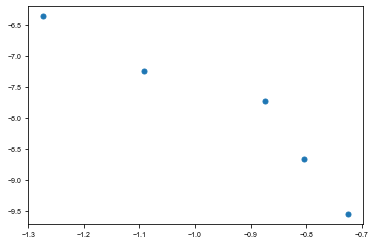

In [31]:
plt.plot(V_peak - 1.5, np.log(Ipeak_minus_Ibaseline_current.to('A').magnitude), 'o')

This looks reasonable. Now, we can sweep through $ E^0 $ to see the resultant value of $k_0$:

In [32]:
n_points = 100

E0_vals = np.linspace(1.0, 2.0, n_points)
k0 = np.zeros((n_points,))

Calculate the prefactor:

In [33]:
prefactor = (0.227 * F * electrode_area * C_EC / ureg.A).to_base_units()
prefactor

6834978.428488977 <Unit('second / meter')>

We now need $k_0$ as a function of $ E_{peak} - E^0 $ and the linear fit parameters:

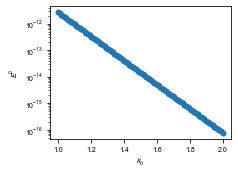

In [34]:
for k, E0 in enumerate(E0_vals):
    
    # Fit
    log_I = np.log(Ipeak_minus_Ibaseline_current.to('A').magnitude)
    fit_for_k0 = np.polyfit(V_peak - E0, log_I, 1)
    
    # Determine slope and intercept of fit
    E0 = E0 * ureg.V
    slope = fit_for_k0[0] / ureg.V
    intercept = fit_for_k0[1]
    
    # Find k0
    k0[k] = ( np.exp(intercept + slope*E0) / prefactor).to('cm/s').magnitude

fig = plt.figure(figsize=(fig_width, fig_height))
plt.semilogy(E0_vals, k0, 'o')
plt.xlabel('$ k_0 $')
plt.ylabel('$ E^0 $')
plt.savefig('E_vs_k.png', dpi=300, bbox_inches='tight')

This is pretty extreme -- Bard and Faulkner state that the lower limit of $ k_0 $ is $ 10^{-10} $. While I expect $ k_0 $  to be low, this is a bit lower than expected.

Calculate alpha from this relationship as well:

In [35]:
alpha = -slope / f
alpha

0.13669202508255335 <Unit('dimensionless')>

This alpha is much smaller than the alpha obtained previously.

## Summary

I'm not very confident in this analysis.
- For $ \alpha $, we get values of both 0.48 and 0.14 via two different methods. These values are very far apart.
- For $ D_0 $, we get a value that is 10 orders of magnitude lower than literature values.
- The relationship between $ k_0 $ and $ E^0 $ is possibly correct, but suspicious enough that, given the results of the other values, I don't quite trust it.

I'm not sure what is causing these discrepancies, but I'll leave this here for someone else to crack.